In [39]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [41]:
import requests 
import pandas as pd 
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from collections import Counter
from geopy.geocoders import Nominatim 
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
import folium 
from sklearn.linear_model import LinearRegression

Download dataset

In [2]:
airData = pd.read_csv('listingsParis.csv' , delimiter = ',')
airData.head(1)

C:\Users\Florence\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (43,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3109,https://www.airbnb.com/rooms/3109,20200315231126,2020-03-16,zen and calm,Appartement très calme de 50M2 Utilisation de ...,I bedroom appartment in Paris 14,I bedroom appartment in Paris 14 Good restaura...,none,Good restaurants very close the Montparnasse S...,...,f,f,flexible,f,f,1,1,0,0,0.23


In [3]:
print("The dataset has {} rows and {} columns.".format(*airData.shape))

The dataset has 67323 rows and 106 columns.


In [4]:
print("The dataset contains {} duplicates.".format(airData.duplicated().sum()))

The dataset contains 0 duplicates.


Define the columns that we keep :

In [5]:
columnsToKeep = ['id', 'name', 'space', 'description','neighbourhood_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'price', 'cleaning_fee', 
                   'security_deposit']
airDataUsed = airData[columnsToKeep].set_index('id')
airDataUsed.head()

,name,space,description,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,amenities,price,cleaning_fee,security_deposit
id,,,,,,,,,,,,,,,,
3109,zen and calm,I bedroom appartment in Paris 14,I bedroom appartment in Paris 14 Good restaura...,Observatoire,48.83349,2.31852,Apartment,Entire home/apt,2,1.0,0.0,Real Bed,"{Internet,Wifi,Kitchen,""Paid parking off premi...",$60.00,$60.00,$150.00
5396,Explore the heart of old Paris,"Small, well appointed studio apartment at the ...","Cozy, well-appointed and graciously designed s...",Hôtel-de-Ville,48.85100,2.35869,Apartment,Entire home/apt,2,1.0,0.0,Pull-out Sofa,"{Internet,Wifi,Kitchen,Heating,Washer,""Smoke d...",$115.00,$36.00,$0.00
7397,MARAIS - 2ROOMS APT - 2/4 PEOPLE,PLEASE ASK ME BEFORE TO MAKE A REQUEST !!! No ...,"VERY CONVENIENT, WITH THE BEST LOCATION ! PLEA...",Hôtel-de-Ville,48.85758,2.35275,Apartment,Entire home/apt,4,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",$119.00,$50.00,$200.00
7964,Large & sunny flat with balcony !,hello ! We have a great 75 square meter apartm...,Very large & nice apartment all for you! - Su...,Opéra,48.87417,2.34245,Apartment,Entire home/apt,2,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Buzzer/w...",$130.00,$60.00,$500.00
9359,"Cozy, Central Paris: WALK or VELIB EVERYWHERE !","Since I live in the USA, it is difficult to ma...",Location! Location! Location! Just bring your ...,Louvre,48.85899,2.34735,Apartment,Entire home/apt,2,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,Elevator,Heating,Essent...",$75.00,$200.00,"$1,500.00"


Keep the "Entire home/apt" in the room type

In [6]:
airDataOnly = airDataUsed.loc[airDataUsed["room_type"]=="Entire home/apt",:]
print("Now, the dataset has {} rows and {} columns.".format(*airDataOnly.shape))

Now, the dataset has 58177 rows and 16 columns.


In [7]:
pricedata = airDataOnly.price.isna().sum()
print("There are {} NaN in price column.".format(pricedata))

There are 0 NaN in price column.


In [8]:
cleaningdata = airDataOnly.cleaning_fee.isna().sum()
print("There are {} NaN in cleaning fee column.".format(cleaningdata))

There are 12337 NaN in cleaning fee column.


In [9]:
securitydata = airDataOnly.security_deposit.isna().sum()
print("There are {} NaN in security deposit column.".format(securitydata))

There are 14767 NaN in security deposit column.


There are plenty of Nan's. It's more than likely that these hosts do not charge any extra cleaning fee and security deposit.

In [10]:
airDataOnly.cleaning_fee.fillna('$0.00', inplace=True)

C:\Users\Florence\Anaconda3\lib\site-packages\pandas\core\generic.py:6244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [11]:
airDataOnly.security_deposit.fillna('$0.00', inplace=True)

Clean up these columns, by method chaining :

In [12]:
airDataOnly.price = airDataOnly.price.str.replace('$', '').str.replace(',', '').astype(float)
airDataOnly.cleaning_fee = airDataOnly.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
airDataOnly.security_deposit = airDataOnly.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)

C:\Users\Florence\Anaconda3\lib\site-packages\pandas\core\generic.py:5302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Show the price column

In [13]:
airDataOnly['price'].describe()

count    58177.000000
mean       123.170841
std        176.401709
min          0.000000
25%         65.000000
50%         89.000000
75%        130.000000
max      10250.000000
Name: price, dtype: float64

Keep the price > $250

In [14]:
airDataOnly.drop(airDataOnly[airDataOnly.price> 250].index,axis=0,inplace=True) 

C:\Users\Florence\Anaconda3\lib\site-packages\pandas\core\frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


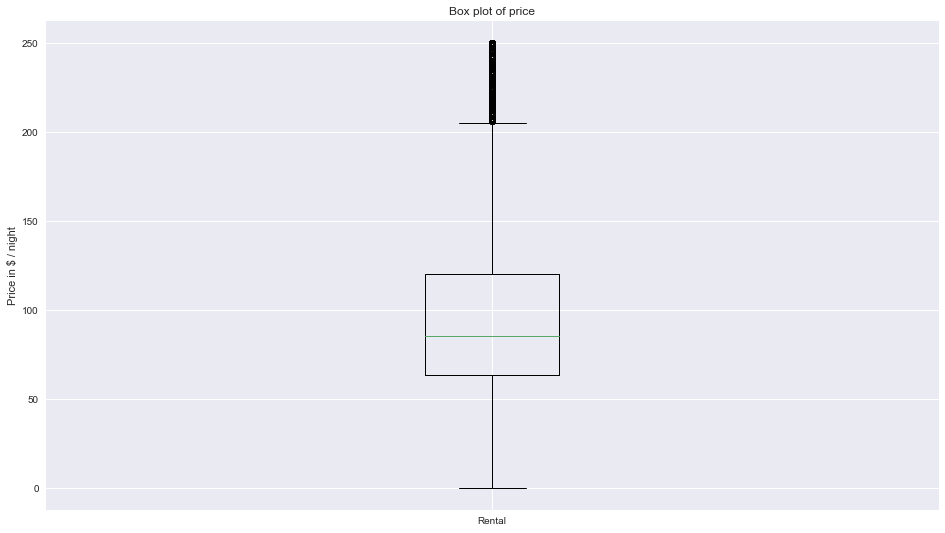

In [15]:
plt.rcParams["figure.figsize"]=[16,9]
plt.boxplot(airDataOnly["price"])
plt.title('Box plot of price')
plt.ylabel('Price in $ / night')
plt.xticks([1], ["Rental"])
plt.draw()
plt.savefig("figure1.png", bbox_inches="tight")

Repartition of price in Paris

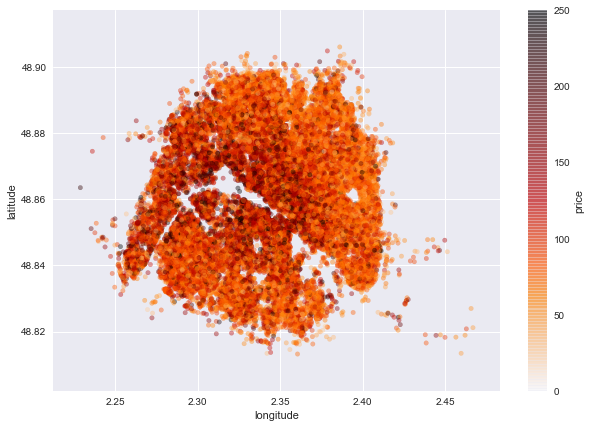

In [16]:
airDataOnly.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), c="price", cmap="gist_heat_r", colorbar=True, sharex=False)
plt.savefig("figure2.png", bbox_inches="tight")

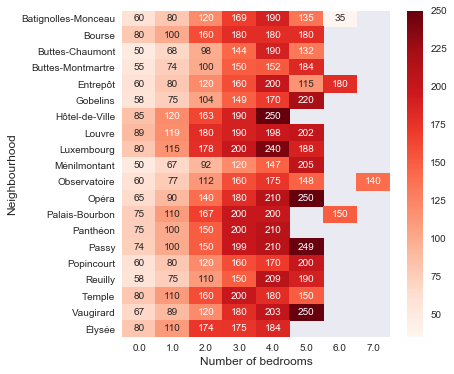

In [17]:
plt.figure(figsize=(6,6))
sns.heatmap(airDataOnly.groupby(['neighbourhood_cleansed', 'bedrooms']).price.median().unstack(), cmap='Reds', annot=True, fmt=".0f")
plt.xlabel('Number of bedrooms', fontsize=12)
plt.ylabel('Neighbourhood', fontsize=12)
plt.savefig("figure3.png", bbox_inches="tight")

Show amenities column

In [18]:
amenitiesResults = Counter()
airDataOnly['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(amenitiesResults.update)
amenitiesResults.most_common(30)

[('Kitchen', 52841),
 ('Heating', 51748),
 ('Essentials', 50972),
 ('Wifi', 50687),
 ('Washer', 42549),
 ('Smoke detector', 38768),
 ('Hangers', 38734),
 ('Hair dryer', 36797),
 ('Iron', 36589),
 ('TV', 35777),
 ('Shampoo', 34244),
 ('Laptop friendly workspace', 33156),
 ('Hot water', 29262),
 ('Refrigerator', 25141),
 ('Dishes and silverware', 24968),
 ('Coffee maker', 20833),
 ('Elevator', 20622),
 ('Cooking basics', 20198),
 ('Bed linens', 19879),
 ('Microwave', 18654),
 ('Oven', 17582),
 ('Internet', 16541),
 ('Family/kid friendly', 16214),
 ('Stove', 16147),
 ('Dryer', 15146),
 ('Cable TV', 12657),
 ('Carbon monoxide detector', 12455),
 ('Dishwasher', 10870),
 ('Host greets you', 10200),
 ('Paid parking off premises', 10121)]

In [19]:
amenitiesData = pd.DataFrame(amenitiesResults.most_common(30), columns=['Amenity', 'Number'])

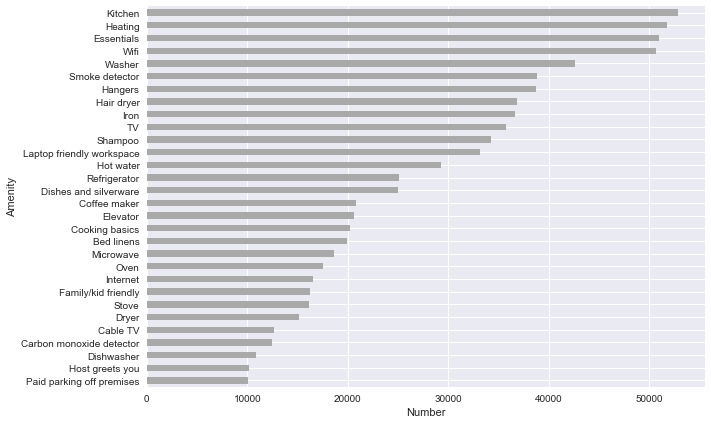

In [20]:
amenitiesData.sort_values(by=['Number'], ascending=True).plot(kind='barh', x='Amenity', y='Number',figsize=(10,7), legend=False, color='darkgrey')
plt.xlabel('Number')
plt.savefig("figure4.png", bbox_inches="tight")

Relation between price, security deposite and cleaning fee

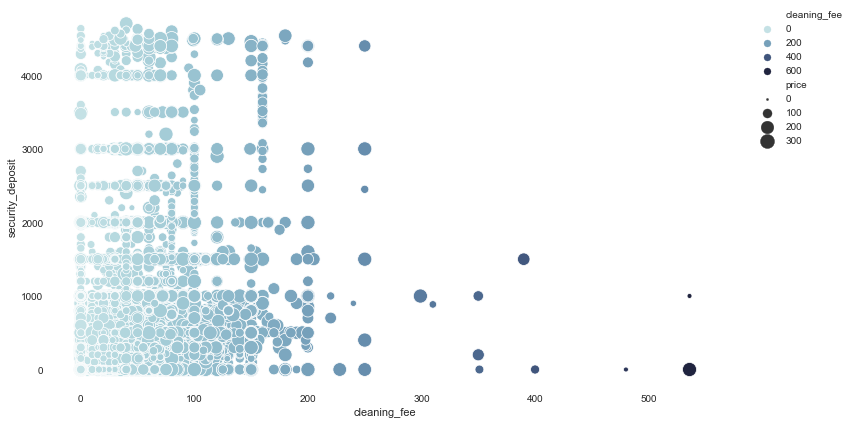

In [21]:
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,7))
ax = sns.scatterplot(x="cleaning_fee", y="security_deposit", size='price', sizes=(5, 200), hue='cleaning_fee', palette=cmap,  data=airDataOnly)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("figure9.png", bbox_inches="tight")

Price by property type

In [22]:
airDataUsed.property_type.value_counts(normalize=True)

Apartment             0.897049
Condominium           0.030747
Boutique hotel        0.021820
Loft                  0.018122
Serviced apartment    0.007382
House                 0.007189
Hotel                 0.004144
Townhouse             0.003773
Bed and breakfast     0.002287
Hostel                0.001708
Other                 0.001574
Guesthouse            0.001396
Guest suite           0.000713
Aparthotel            0.000594
Tiny house            0.000490
Villa                 0.000312
Boat                  0.000193
Houseboat             0.000104
Earth house           0.000045
Bungalow              0.000045
Cave                  0.000045
Nature lodge          0.000030
Farm stay             0.000030
Barn                  0.000030
Cottage               0.000030
Cabin                 0.000030
Dome house            0.000030
Island                0.000015
Camper/RV             0.000015
Dorm                  0.000015
Igloo                 0.000015
Campsite              0.000015
Plane   

In [23]:
typeprice = airDataOnly.groupby("property_type")["price"].agg(['mean'])
typeprice

,mean
property_type,
Aparthotel,137.857143
Apartment,94.795159
Barn,150.000000
Bed and breakfast,88.000000
Boat,115.000000
Bungalow,93.000000
Campsite,25.000000
Cave,138.500000
Condominium,99.387668


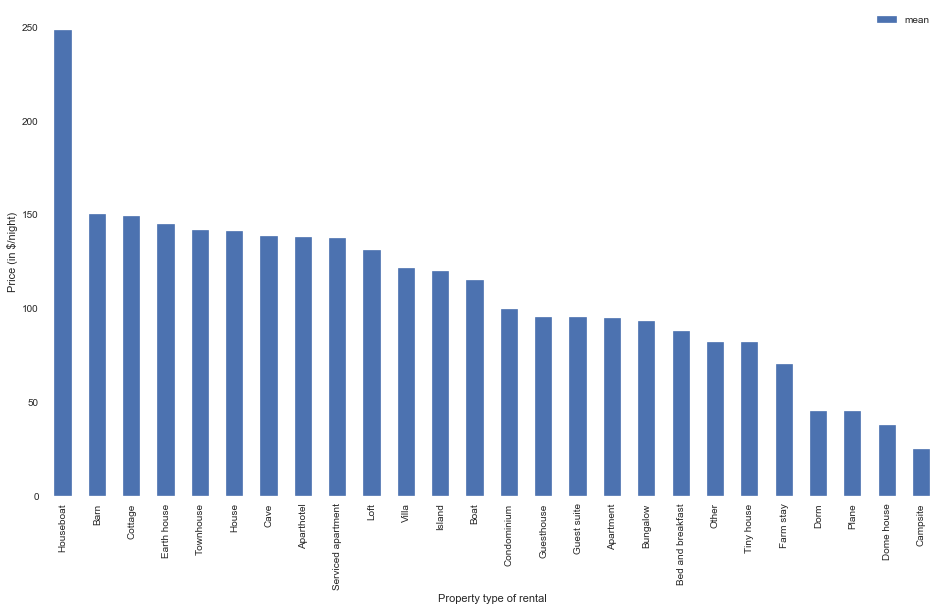

In [24]:
chart3 = typeprice.sort_values(by='mean', ascending=False).plot(kind = "bar")
chart3.set_ylabel('Price (in $/night)')
chart3.set_xlabel('Property type of rental')
plt.savefig("figure7.png", bbox_inches="tight")

In [25]:
neighbourhoodPrice = airDataOnly.groupby("neighbourhood_cleansed")["price"].agg(['mean'])
neighbourhoodPrice.sort_values(by='mean', ascending=False)

,mean
neighbourhood_cleansed,
Louvre,124.358586
Hôtel-de-Ville,123.812725
Élysée,122.829355
Luxembourg,121.716282
Palais-Bourbon,117.703676
Temple,117.526336
Bourse,113.520397
Passy,111.552293
Panthéon,109.898486


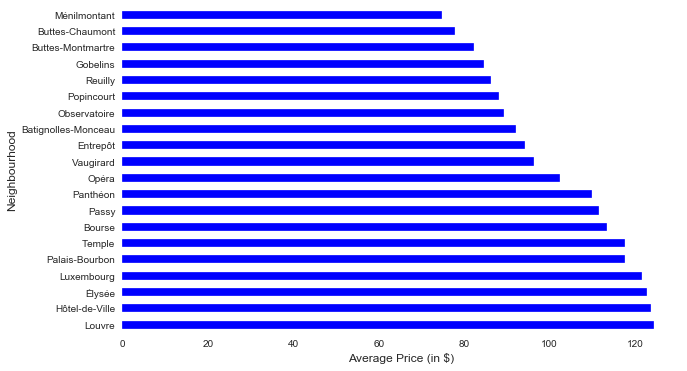

In [26]:
neighbourhoodPrice.sort_values(by='mean', ascending=False).plot(kind='barh', figsize=(10,6), legend=False, color='blue')
plt.xlabel('Average Price (in $)', fontsize=12)
plt.ylabel('Neighbourhood', fontsize=12)
plt.savefig("figure5.png", bbox_inches="tight")

Creation of choropleth map

In [27]:
import json
parisgeo = json.load(open("arrondissements.geojson"))

In [28]:
parisMap = folium.Map(location = [48.85, 2.29], zoom_start = 12)
parisMap.choropleth(geo_data = parisgeo, key_on = "feature.properties.l_aroff",
                 data = airDataOnly, columns = ["neighbourhood_cleansed", "price"],
                   fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
               legend_name='Price (in $/night) of Airbnb')

parisMap

In [29]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


Download Foursquare location data

In [30]:
CLIENT_ID = 'PB1FKRKV45MBPO4QNCXXSFUBOPFG1W4DYQZXVJEMGBRCWTU0' # my Foursquare ID
CLIENT_SECRET = 'TZUKZ1H3C154HLB2L4SV2UIHQDL11LLSRL0LHPGZUGCUSR4C' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 50

In [31]:
address = 'Paris, France, P'
geolocator = Nominatim(user_agent="P_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris City are 48.8566969, 2.3514616.


In [32]:
search_query_bakery = 'Boulangerie'
search_query_subway = 'Metro'
search_query_market = 'Supermarche'

In [33]:
urlMarket = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_market,LIMIT)

In [34]:
urlBakery = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_bakery, LIMIT)

In [35]:
urlSubway = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_subway, LIMIT)

In [42]:
resultsMarket = requests.get(urlMarket).json()

In [43]:
resultsBakery = requests.get(urlBakery).json()

In [44]:
resultsSubway = requests.get(urlSubway).json()

In [45]:
# assign relevant part of JSON to venues
venuesBakery = resultsBakery['response']['venues']

# tranform venues into a dataframe
dataframeBakery = json_normalize(venuesBakery)

C:\Users\Florence\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


In [46]:
# assign relevant part of JSON to venues
venuesSubway = resultsSubway['response']['venues']

# tranform venues into a dataframe
dataframeSubway = json_normalize(venuesSubway)

C:\Users\Florence\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


In [47]:
# assign relevant part of JSON to venues
venuesMarket = resultsMarket['response']['venues']

# tranform venues into a dataframe
dataframeMarket = json_normalize(venuesMarket)

C:\Users\Florence\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


In [48]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columnsBakery = ['name', 'categories'] + [col for col in dataframeBakery.columns if col.startswith('location.')] + ['id']
dataframe_filteredBakery = dataframeBakery.loc[:, filtered_columnsBakery]

# function that extracts the category of the venue
def get_category_typeBakery(row):
    try:
        categories_listBakery = row['categories']
    except:
        categories_listBakery = row['venueBakery.categories']
        
    if len(categories_listBakery) == 0:
        return None
    else:
        return categories_listBakery[0]['name']

# filter the category for each row
dataframe_filteredBakery['categories'] = dataframe_filteredBakery.apply(get_category_typeBakery, axis=1)

# clean column names by keeping only last term
dataframe_filteredBakery.columns = [column.split('.')[-1] for column in dataframe_filteredBakery.columns]

In [49]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columnsSubway = ['name', 'categories'] + [col for col in dataframeSubway.columns if col.startswith('location.')] + ['id']
dataframe_filteredSubway = dataframeSubway.loc[:, filtered_columnsSubway]

# function that extracts the category of the venue
def get_category_typeSubway(row):
    try:
        categories_listSubway = row['categories']
    except:
        categories_listSubway = row['venueSubway.categories']
        
    if len(categories_listSubway) == 0:
        return None
    else:
        return categories_listSubway[0]['name']

# filter the category for each row
dataframe_filteredSubway['categories'] = dataframe_filteredSubway.apply(get_category_typeSubway, axis=1)

# clean column names by keeping only last term
dataframe_filteredSubway.columns = [column.split('.')[-1] for column in dataframe_filteredSubway.columns]

In [50]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columnsMarket = ['name', 'categories'] + [col for col in dataframeMarket.columns if col.startswith('location.')] + ['id']
dataframe_filteredMarket = dataframeMarket.loc[:, filtered_columnsMarket]

# function that extracts the category of the venue
def get_category_typeMarket(row):
    try:
        categories_listMarket = row['categories']
    except:
        categories_listMarket = row['venueMarket.categories']
        
    if len(categories_listMarket) == 0:
        return None
    else:
        return categories_listMarket[0]['name']

# filter the category for each row
dataframe_filteredMarket['categories'] = dataframe_filteredMarket.apply(get_category_typeMarket, axis=1)

# clean column names by keeping only last term
dataframe_filteredMarket.columns = [column.split('.')[-1] for column in dataframe_filteredMarket.columns]

In [51]:
parisresult = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

parisresult.choropleth(geo_data = parisgeo , key_on = "feature.properties.l_aroff",
                 data = airDataOnly, columns = ["neighbourhood_cleansed", "price"],
                   fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.1,
               legend_name='Price (in $/night) of Airbnb') 

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filteredMarket.lat, dataframe_filteredMarket.lng, dataframe_filteredMarket.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(parisresult)

    # add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filteredSubway.lat, dataframe_filteredSubway.lng, dataframe_filteredSubway.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        popup=label,
        fill = True,
        fill_color='black',
        fill_opacity=0.6
    ).add_to(parisresult)

     # add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filteredBakery.lat, dataframe_filteredBakery.lng, dataframe_filteredBakery.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(parisresult)   
      
    
# display map
parisresult